<h1 style="font-size:300%">How to Calculate Market Breadth</h1>
<p>James Dellinger, October 1, 2021</p>
<a href="https://twitter.com/jamrdell"><img alt="twitter logo" src="images/Twitter_Logo_Blue.png" width="35" align="left"/></a>

Thanks to [San](https://twitter.com/sanntrades)'s prior [recommendation](https://twitter.com/sanntrades/status/1345944235971928065), I've been using [Breadth.app](https://breadth.app/breadth)'s SPX breadth indicator on a daily basis to get a feel for where we are in the market's [breadth cycle](https://www.investopedia.com/terms/m/market_breadth.asp). 

Given that the site loads in Chinese and has a link to an English version that only appears sporadically, it wasn't immediately clear to me exactly how their market breadth score was calculated. Though after poking around through the repos of some of the site's contributors, I saw that the formula is [quite simple](https://github.com/tianyuan09/financialdataInR/blob/6376b5dac0830f341d1de020a2c3f0e887a8bbd9/MarketDashboard.Rmd#L91):
1. For each of the eleven SPX sectors, find the percentage of stocks in the sector that closed the day above their 20 day SMA.
2. Add up these eleven percentages to get the total market breadth score. The max is 1100 and min is 0.

In this notebook, I'll show how to write some Python functions that'll generate the same market breadth graph that you'd find on the breadth.app website. This might be useful if **(a)** you'd like to confirm that this stuff isn't as intimidating as it might initially seem, and or **(b)** you're interested in experimenting with an alternative comparison point such as the 50 day EMA. 

Before going any further, here's what the end product will look like:

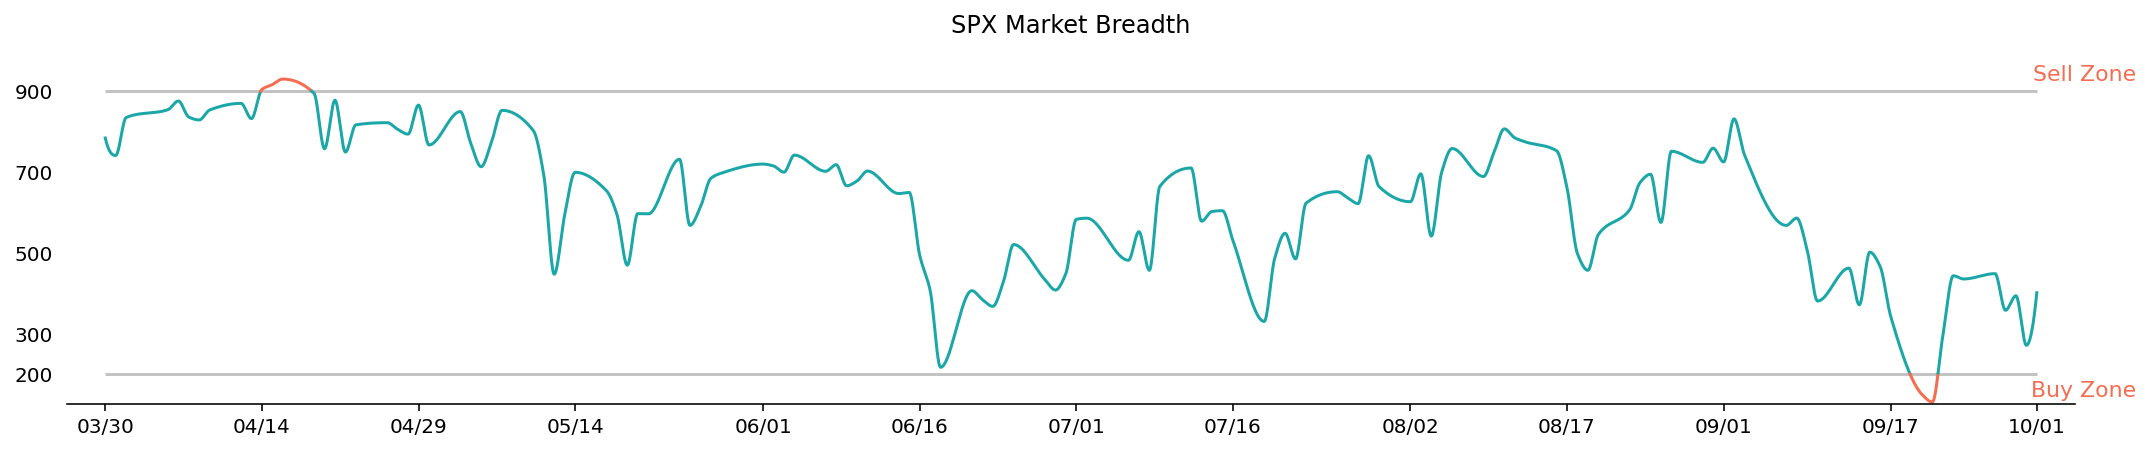

In [13]:
plot_breadth(mkt_breadth_six_mo, single_sector=False)

#### Acknowledgements
Breadth.app was originally created by [@lonecapital](https://twitter.com/LoneCapital) and as best as I can tell, uses a [codebase](https://github.com/bankrollhunter/market-breadth) written by [hk-lei](https://github.com/hk-Lei) and [kentio](https://github.com/kentio). The site also incorporates design work done by [jchang274](https://github.com/jchang274) and [tianyuan09](https://github.com/tianyuan09/financialdataInR). With the exception of the Wikipedia scraping function, which I [borrow directly](https://github.com/bankrollhunter/market-breadth/blob/70df4e75b17c2c462cdb2cb06b50e482083fc275/tools/util/us.py#L26) from hk-lei, all of the code that follows below is my own creation. 

Nonetheless, the authors' [repo](https://github.com/bankrollhunter/market-breadth) was a crucial reference that helped me confirm, generally-speaking, what steps are necesssary to generate SPX market breadth data from scratch. Their work clued me in to the fact that the [TA-Lib](https://mrjbq7.github.io/ta-lib/) library makes it easy to calculate SMAs, EMAs, etc., and that [yfinance](https://pypi.org/project/yfinance/) makes for a user-friendly and free way to download the market data for all SPX stocks.

# Step 1: Get all 505 SPX ticker symbols and their sector abbreviations
We'll eventually use this info to download individual stock daily price data from Yahoo Finance.

In [1]:
import numpy as np
import yfinance as yf
from bs4 import BeautifulSoup
import requests
import pandas as pd
import talib as ta
import time
from datetime import date, timedelta
from scipy.interpolate import pchip_interpolate
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
HEADERS = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) ' + 
           'AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.159 Safari/537.36'}

spx_sector_abbrev = {'Industrials': 'IND', 
                     'Health Care': 'HLT', 
                     'Information Technology': 'TEC',
                     'Communication Services': 'COM', 
                     'Consumer Discretionary': 'CND', 
                     'Utilities': 'UTL',
                     'Financials': 'FIN', 
                     'Materials': 'MAT', 
                     'Real Estate': 'REI', 
                     'Consumer Staples': 'CNS',
                     'Energy': 'ENE'}

def get_spx_tickers():
    """Get ticker symbol, sector, and sector abbreviation for all 505 SPX stocks.
    Borrows from code by hk-lei at: 
    https://github.com/bankrollhunter/market-breadth/blob/70df4e75b17c2c462cdb2cb06b50e482083fc275/tools/util/us.py
            
    Returns:
        Dataframe containing each ticker's info.
    """
    url = 'http://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    res = requests.get(url, headers=HEADERS)
    bs = BeautifulSoup(res.text, 'lxml')
    table = bs.find('table', {'class': 'wikitable sortable'})
    tags = table.find_all('tr')[1:]
    symbols, sectors = [], []
    for t in tags:
        symbols.append(t.find_all('td')[0].get_text().replace('\n', ''))
        sectors.append(t.find_all('td')[3].get_text().replace('\n', ''))
    tickers_df = pd.DataFrame({'SPX Ticker': symbols, 'Sector': sectors, 
                               'Sector Abbrev': [spx_sector_abbrev[s] for s in sectors]})
    # Yahoo finance uses a dash instead of a dot for symbols BRK.B and BF.B
    tickers_df['SPX Ticker'] = tickers_df['SPX Ticker'].str.replace('.', '-')
    return tickers_df

Here's what the scraped SPX data looks like, for the final few tickers:

In [3]:
spx_tickers = get_spx_tickers()
spx_tickers[-3:]

,SPX Ticker,Sector,Sector Abbrev
502,ZBH,Health Care,HLT
503,ZION,Financials,FIN
504,ZTS,Health Care,HLT


# Step 2: Get detailed daily data for all stocks in a single SPX sector
The [yfinance](https://pypi.org/project/yfinance/) library makes it easy to download daily OHLC data for several stocks at once from Yahoo Finance. I do just one sector at a time because if one were to attempt to grab daily data for too many stocks at once, there's a chance that the data Yahoo returns will leave some days blank.

After receiving a stock's daily price data, I calculate its 20 day SMA and 50 day EMA, and then generate two columns that indicate (True/False) whether each stock closed above those reference points each day.

In [4]:
def get_sector_data(sector_abbrev, spx_tickers):
    """Get OHLC, 20-day SMA, and 50-day EMA for the past year for each stock in a single SPX sector.
    
    Arguments:
        sector_abbrev         (string): An SPX sector abbreviation. i.e. "UTL"
        spx_tickers (Pandas DataFrame): Holds ticker symbol and sector abbreviation for all SPX stocks.
        
    Returns:
        2-level column index w/ Date row index DataFrame containing the following data for each stock 
        in a SPX sector over the previous year: OHLC, 20-day SMA, whether close > 20-day SMA, 
        50-day EMA, whether close > 50-day EMA.
    """
    sector_tickers = spx_tickers[spx_tickers['Sector Abbrev']==sector_abbrev]['SPX Ticker'].values
    data = yf.download(' '.join(sector_tickers), period = '1y', group_by="ticker", 
                       threads=False, auto_adjust=True, interval='1d')
    for t in sector_tickers:
        close = data[t]['Close'].values
        data[t, '20 Day SMA'] = ta.SMA(close, timeperiod=20)
        data[t, '50 Day EMA'] = ta.EMA(close, timeperiod=50)
        data[t, 'Close Above 20 Day SMA'] = data[t]['Close'] > data[t]['20 Day SMA']
        data[t, 'Close Above 50 Day EMA'] = data[t]['Close'] > data[t]['50 Day EMA']
    data = data.sort_index(axis=1)
    return data

Here's what the most recent five days the daily data looks like for the `UTL` sector:

In [5]:
utl_data = get_sector_data('UTL', spx_tickers)
utl_data[-5:]

[*********************100%***********************]  28 of 28 completed


AEE                                               \
           20 Day SMA 50 Day EMA      Close Close Above 20 Day SMA   
Date                                                                 
2021-09-27  85.689027  85.216399  82.199997                  False   
2021-09-28  85.363146  85.067521  81.419998                  False   
2021-09-29  85.121524  84.960559  82.339996                  False   
2021-09-30  84.761227  84.805243  81.000000                  False   
2021-10-01  84.370499  84.640723  80.610001                  False   

                                                                             \
           Close Above 50 Day EMA       High        Low       Open   Volume   
Date                                                                          
2021-09-27                  False  84.260002  82.089996  83.650002  1068500   
2021-09-28                  False  82.260002  80.930000  81.839996  1084300   
2021-09-29                  False  82.889999  81.360001  81.400002   955100   
2021-09-30                  False  82.330002  80.820000  82.260002  1509700   
2021-10-01                  False  81.510002  80.459999  81.500000   887534   

                  AEP  ...      WEC        XEL                        \
           20 Day SMA  ...   Volume 20 Day SMA 50 Day EMA      Close   
Date                   ...                                             
2021-09-27  86.907001  ...   830600  66.160798  66.769010  62.250000   
2021-09-28  86.490001  ...  1217000  65.803864  66.559245  61.419998   
2021-09-29  86.120001  ...   944300  65.523333  66.406726  62.669998   
2021-09-30  85.654001  ...  1203900  65.184645  66.253521  62.500000   
2021-10-01  85.176501  ...  1074393  64.817151  66.105932  62.490002   

                                                                     \
           Close Above 20 Day SMA Close Above 50 Day EMA       High   
Date                                                                  
2021-09-27                  False                  False  63.709999   
2021-09-28                  False                  False  62.430000   
2021-09-29                  False                  False  63.049999   
2021-09-30                  False                  False  63.020000   
2021-10-01                  False                  False  63.720001   

                                           
                  Low       Open   Volume  
Date                                       
2021-09-27  62.180000  63.220001  3321400  
2021-09-28  61.160000  62.279999  4454500  
2021-09-29  61.200001  61.490002  3013500  
2021-09-30  62.240002  62.619999  3965800  
2021-10-01  62.410000  63.700001  4211925  

[5 rows x 252 columns]

# Step 3: Calculate Sector Breadth
We'll use the stock data from a single sector to calculate that sector's daily market breadth, which is the percent of stocks in the sector that closed above a certain reference point. I'll default to using the 20 day SMA just like breadth.app, though we could use whatever comparison we preferred: 20/50/100 day SMA/EMA, etc. 

In [6]:
def get_sector_breadth(sector_data, sector_abbrev, comparison='Close Above 20 Day SMA'):
    """Get daily market breadth for a single SPX sector.
    
    Arguments:
        sector_data (Pandas DataFrame): 2-level column index w/ Date row index DataFrame with at least
                                        one column indicating (True/False) whether stocks closed above
                                        a certain point, e.g. their 20 day SMA.                            
        sector_abbrev         (string): An SPX sector abbreviation. i.e. "UTL"
        comparison            (string): Name of column in sector_data df that indicates whether stock closed
                                        above desired reference point on a given day.
        
    Returns:
        Pandas series with Date index that contains an SPX sector's market breadth for each day.
    """
    num_tickers = len(sector_data.columns.get_level_values(0).unique())
    breadth = sector_data.sum(axis = 1, level = 1)[comparison]/num_tickers*100
    breadth.rename(sector_abbrev + ' Breadth', inplace=True)
    return breadth

Here's the most recent 5 days of breadth data for `UTL`:

In [7]:
utl_breadth = get_sector_breadth(utl_data, 'UTL')
utl_breadth[-5:]

Date
2021-09-27    0.0
2021-09-28    0.0
2021-09-29    0.0
2021-09-30    0.0
2021-10-01    0.0
Name: UTL Breadth, dtype: float64

# Step 4: Calculating SPX Market Breadth
Our final task is to use the two functions above to calculate daily breadth for each of the 11 SPX sectors and add these together to get the overall SPX market breadth.

First let's get the daily stock data and use this to calculate the daily breadth for each sector:

In [8]:
sector_data = {}
sector_breadth = {}
for i, sector in enumerate(spx_sector_abbrev.values()):
    data = get_sector_data(sector, spx_tickers)
    breadth = get_sector_breadth(data, sector)
    sector_data[sector], sector_breadth[sector] = data, breadth
    if i < len(spx_sector_abbrev.values()) - 1:   # Take a break in between each sector so we 
        time.sleep(60)                            # don't get rate-limited by Y! Finance.

[*********************100%***********************]  74 of 74 completed
[*********************100%***********************]  64 of 64 completed
[*********************100%***********************]  74 of 74 completed
[*********************100%***********************]  27 of 27 completed
[*********************100%***********************]  63 of 63 completed
[*********************100%***********************]  28 of 28 completed
[*********************100%***********************]  65 of 65 completed
[*********************100%***********************]  28 of 28 completed
[*********************100%***********************]  29 of 29 completed
[*********************100%***********************]  32 of 32 completed
[*********************100%***********************]  21 of 21 completed


Now we just add together all 11 sector daily breadths to get the SPX market breadth for each day.

In [9]:
def get_spx_breadth(sector_breadth): 
    """Get daily SPX market breadth.
    
    Arguments:
        sector_breadth (dict): Contains daily market breadth for each of SPX's 11 sectors. 
        
    Returns:
        Pandas series with Date index that contains the SPX's market breadth for each day.
    """
    return pd.DataFrame(sector_breadth.values()).T.sum(axis=1)

Here's SPX market breadth for the most recent 5 days:

In [10]:
market_breadth = get_spx_breadth(sector_breadth)
market_breadth[-5:]

Date
2021-09-27    448.573551
2021-09-28    357.999722
2021-09-29    393.785655
2021-09-30    271.286268
2021-10-01    401.334846
dtype: float64

# Plotting Market Breadth
Our work wouldn't be complete if we didn't try and plot some nice looking graphs.

In [11]:
RED, GREEN, GRAY = '#f56c51', '#1ba7a7', '#c3c3c3'

def plot_breadth(data, single_sector=False, title='SPX Market Breadth'):
    """Display a graph of daily market breadth.
    
    Arguments:
        data (Pandas Series w/ Date Index): Daily market breadths.
        single_sector               (Bool): Whether market breadth graph is for all of SPX
                                            or just one SPX sector.
        title                     (string): Desired title for the graph.
    """
    X_, Y_ = smooth_time_series(data)
    fig = plt.figure(figsize=[18,3])
    ax = fig.add_subplot(1, 1, 1)
    for border in ['left', 'right', 'top']: ax.spines[border].set_visible(False)
    for tick in ax.yaxis.get_major_ticks(): tick.tick1line.set_visible(False)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax.set_xticks([data.index[i*len(data)//12] for i in range(12)] + [data.index[-1]])
    ax.margins(x=0.02); ax.margins(y=0.005)
    if single_sector:
        ax.set_title(data.name, y=1.1)
        ax.plot(X_, Y_, color=GREEN)
    else:
        # If plotting entire SPX breadth, draw lines to show buy (走货区) and sell (狩猎区) zones.
        ax.set_yticks([200, 300, 500, 700, 900])
        ax.hlines([200, 900], X_[0], X_[-1], colors=GRAY)
        ax.text(1.03, 1.04, 'Sell Zone', verticalalignment='top', horizontalalignment='right',
                                        transform=ax.transAxes, color='#f56c51', fontsize=11)
        ax.text(1.03, 0.01, 'Buy Zone', verticalalignment='bottom', horizontalalignment='right',
                                        transform=ax.transAxes, color='#f56c51', fontsize=11)
        ax.set_title(title, y=1.1)
        # Also draw buy and sell zone parts of graph in red.
        for s in segment_breadth_data(Y_): ax.plot(X_[s[0]: s[1]], Y_[s[0]: s[1]], color=s[2])
            
def smooth_time_series(data):
    """Use pchip algorithm to interpolate a 1-d dataset with Date index to plot a smoother graph.
    
    Arguments:
        data (Pandas Series w/ Date Index): 1-d points to be graphed
        
    Returns:
        Two interpolated series, one for the date index and other containing the data.
    """
    x = np.array([i.value for i in data.index])
    y = np.array(data.values)
    X_ = np.linspace(x.min(), x.max(), 10000)
    Y_ = pchip_interpolate(x, y, X_)
    X_ = pd.to_datetime(X_)
    return X_, Y_

def segment_breadth_data(data, i=0):
    """Find the sell zones (>=900) and buy zones (<=200) for SPX market breadth data.
    
    Arguments:
        data (array): A series of market breadth data.
        i      (int): Start index.
        
    Returns:
        A list of tuples, each containing the start index, end index, and color 
        to be used to draw each segment of an SPX market breadth graph.
    """
    start_idx = i
    
    if data[i] >= 900: # Sell Zone
        draw_color = RED
        while data[i] >= 900: 
            i += 1
            if i == len(data): return [(start_idx, i, draw_color)]
    elif data[i] <= 200: # Buy Zone
        draw_color = RED
        while data[i] <= 200: 
            i += 1
            if i == len(data): return [(start_idx, i, draw_color)]
    else: 
        draw_color = GREEN
        while data[i] > 200 and data[i] < 900: 
            i += 1
            if i == len(data): return [(start_idx, i, draw_color)]
    return [(start_idx, i, draw_color)] + segment_breadth_data(data, i)

Here's SPX Market Breadth (based on the 20 day SMA) for the past six months:

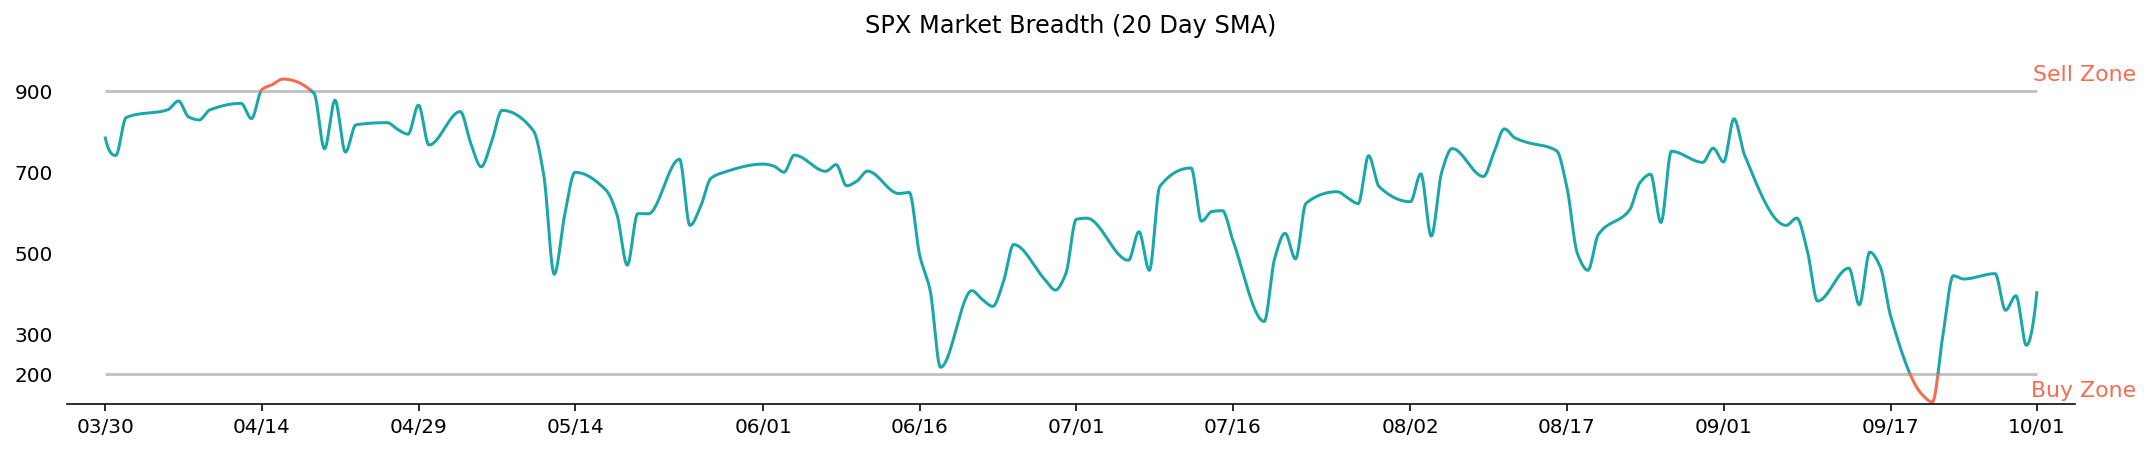

In [12]:
mkt_breadth_six_mo = market_breadth[(date.today() - timedelta(days=185)).strftime("%Y-%m-%d"):]
plot_breadth(mkt_breadth_six_mo, single_sector=False, title='SPX Market Breadth (20 Day SMA)')

Here's a screen grab direct from breadth.app for the same date range, and it's clear both graphs look pretty similar. I believe the slight differences in slope and curvature of the two graphs are because breadth.app uses a different algorithm to smooth the lines that connect each discrete point of daily market breadth data:

<img src="images/breadth_0330_to_1001.png" alt="Market Breadth 3-30-2021 to 10-1-2021" width="1100" align="left"/>

We can also easily graph daily market breadth for each individual sector:

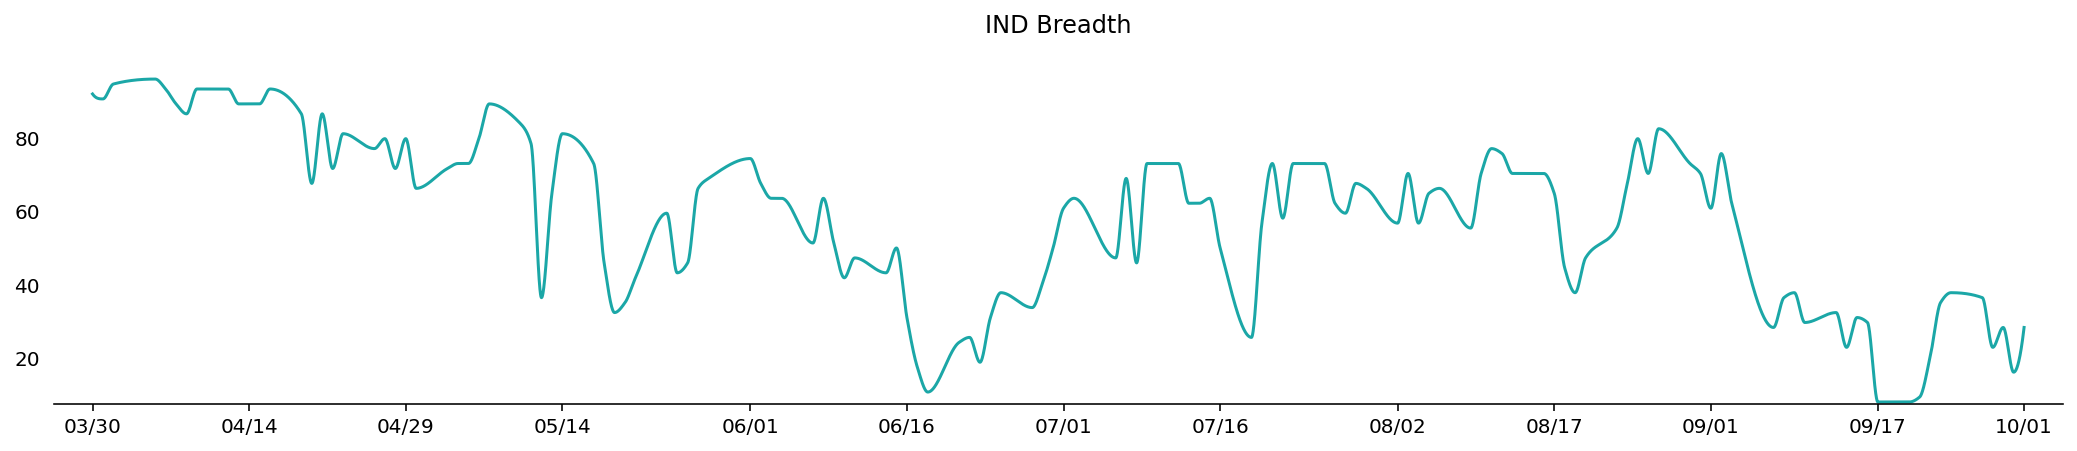

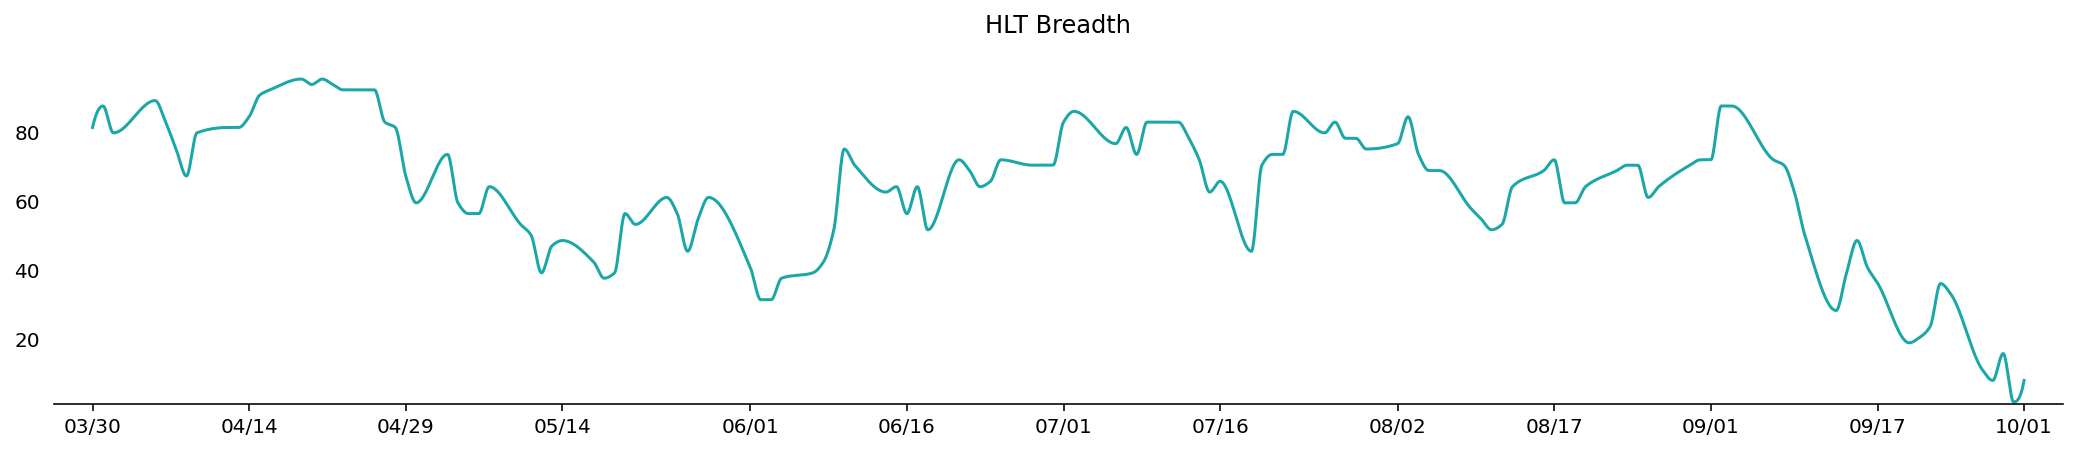

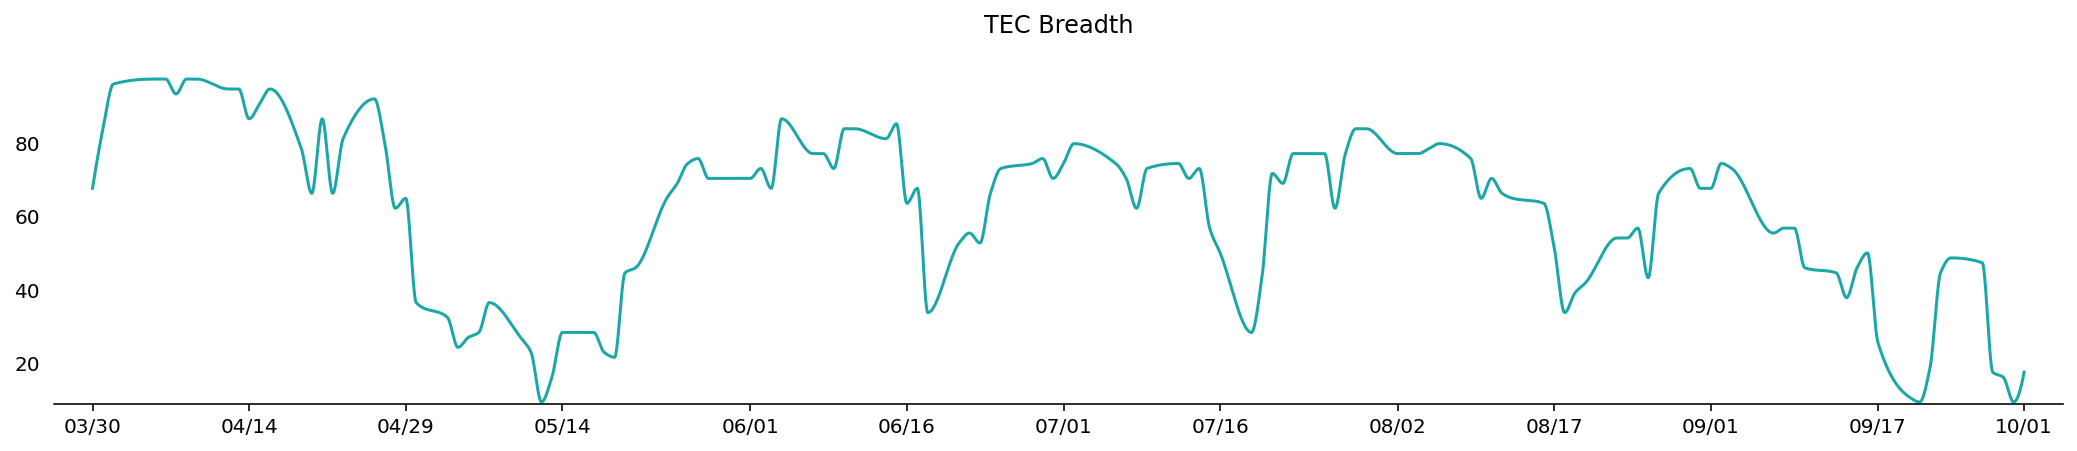

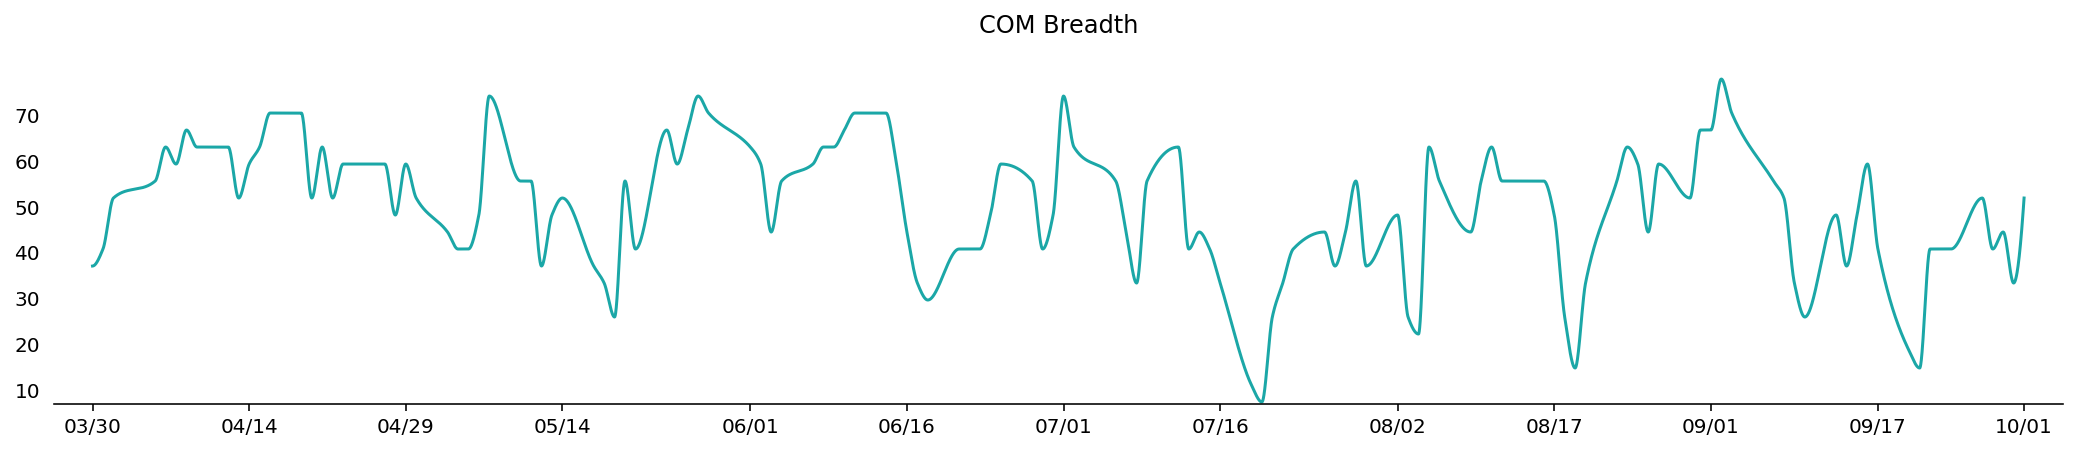

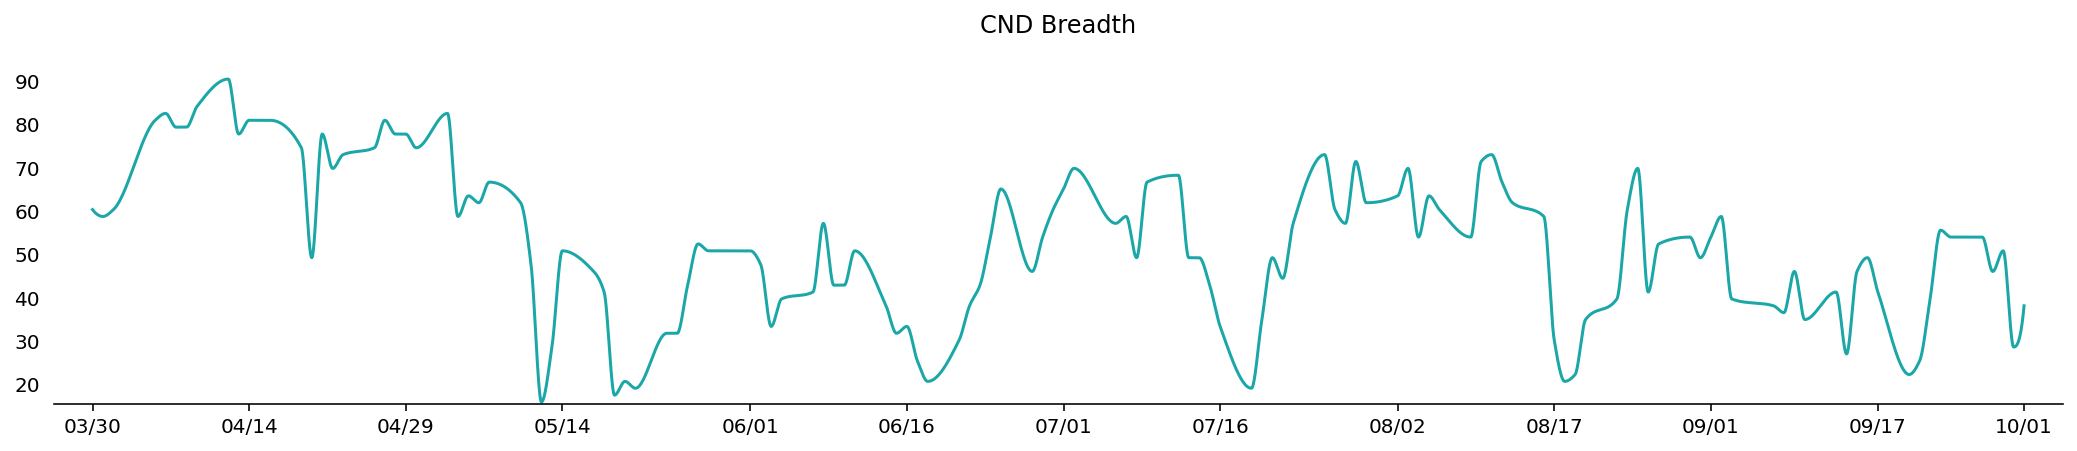

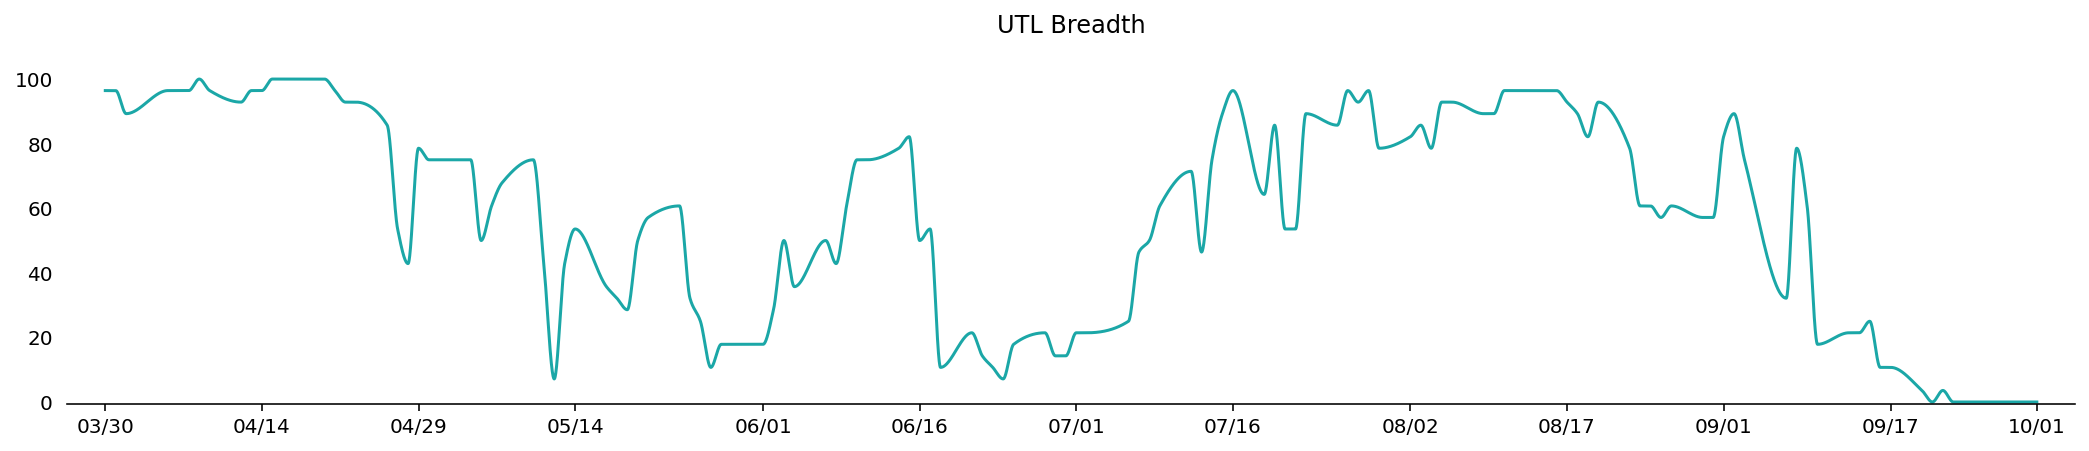

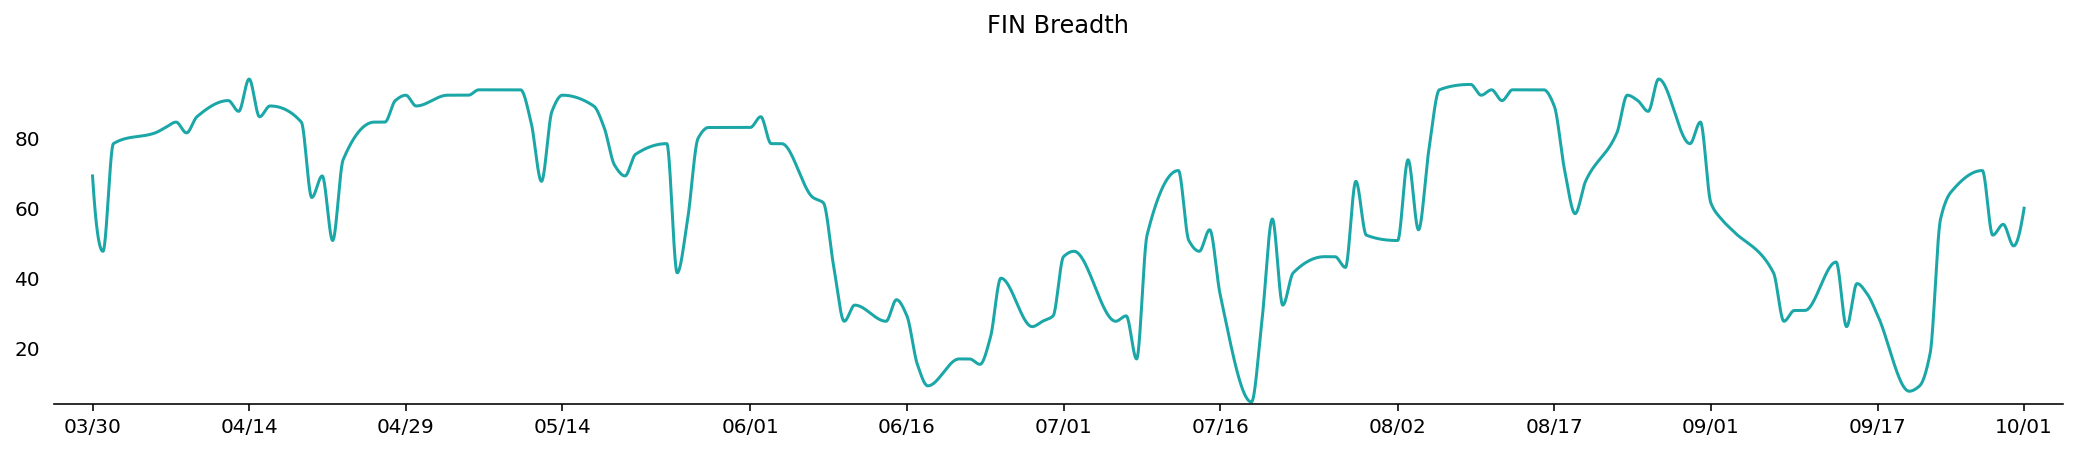

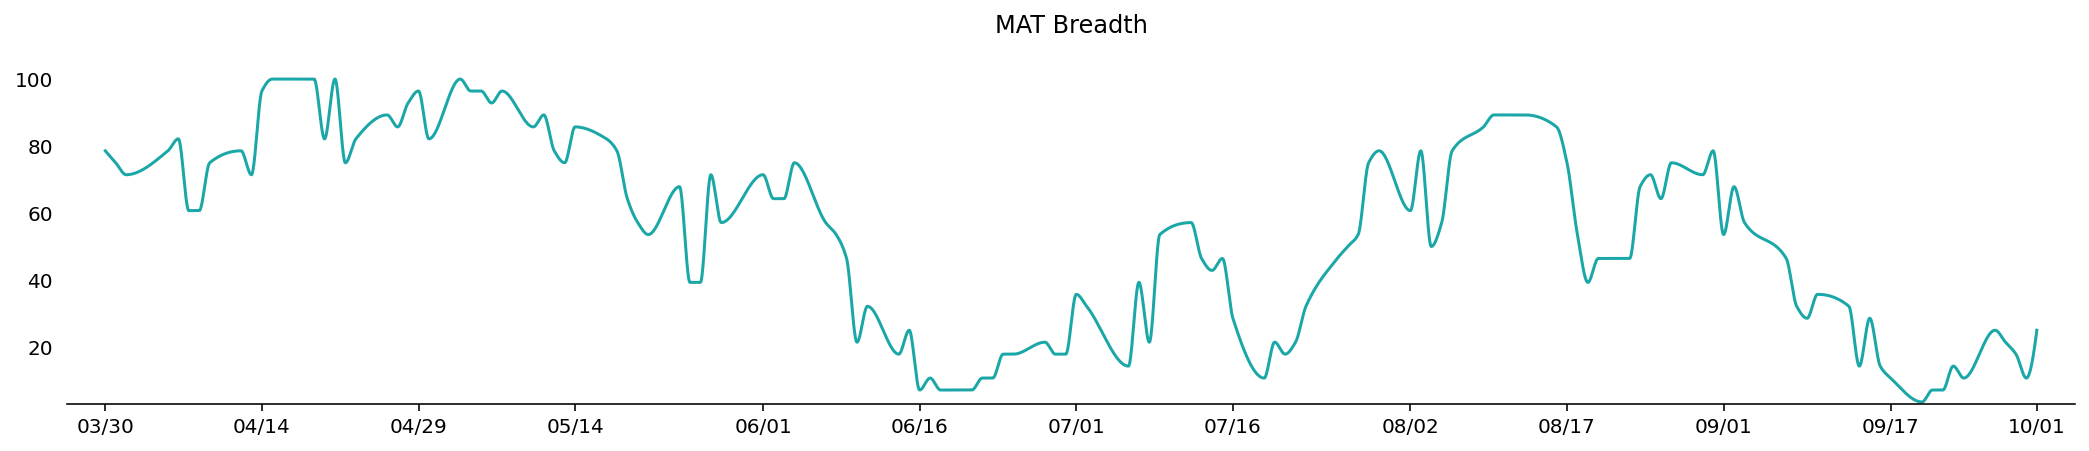

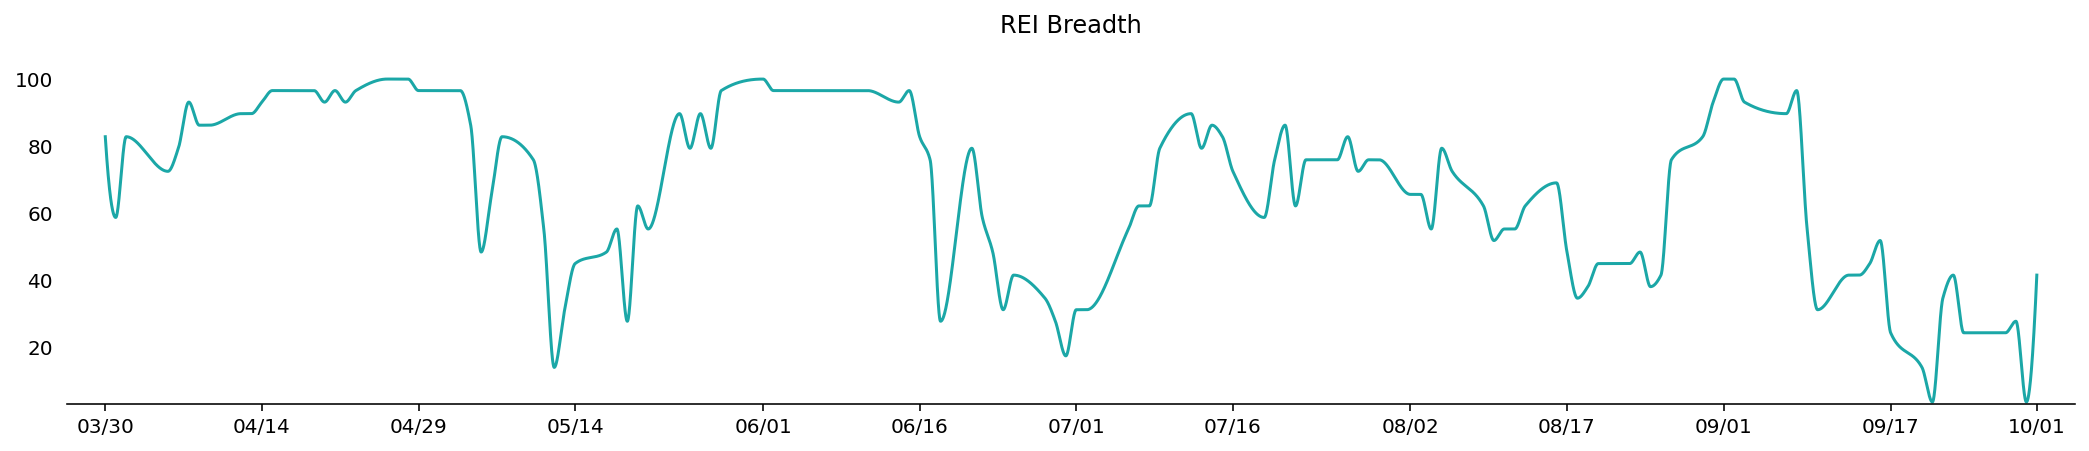

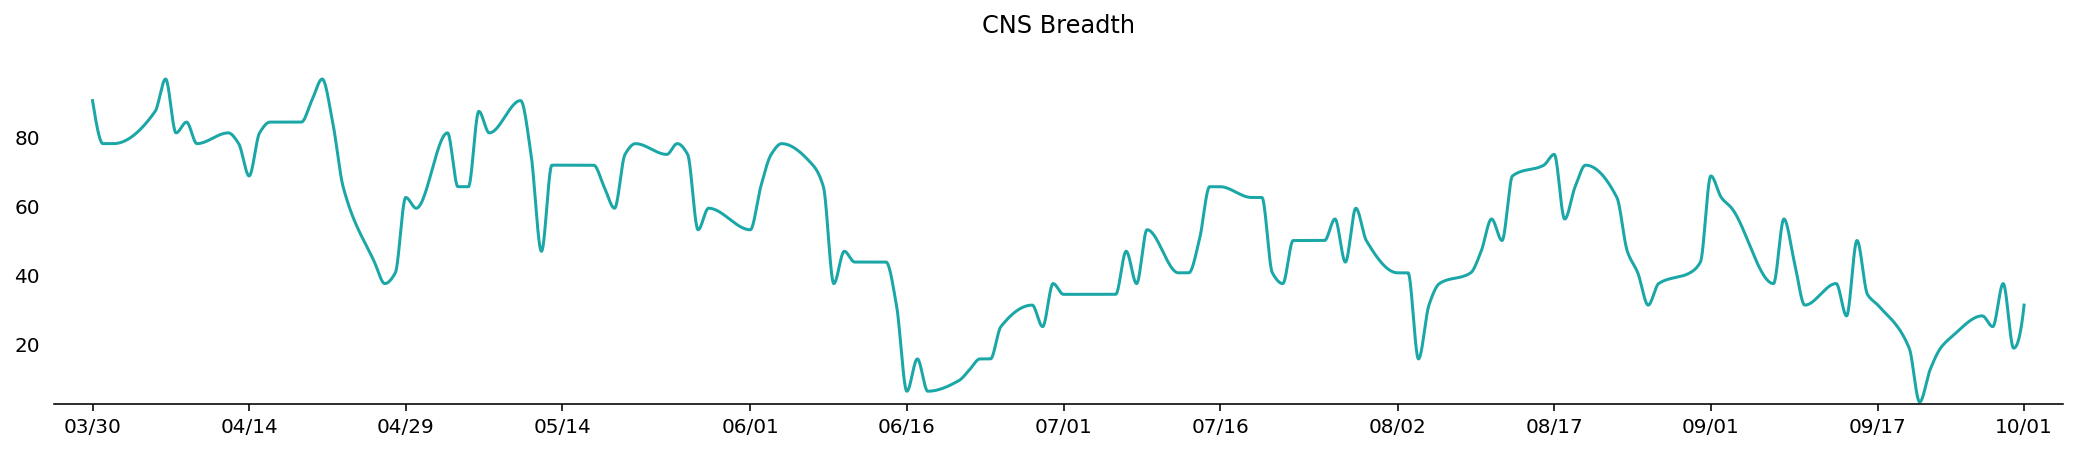

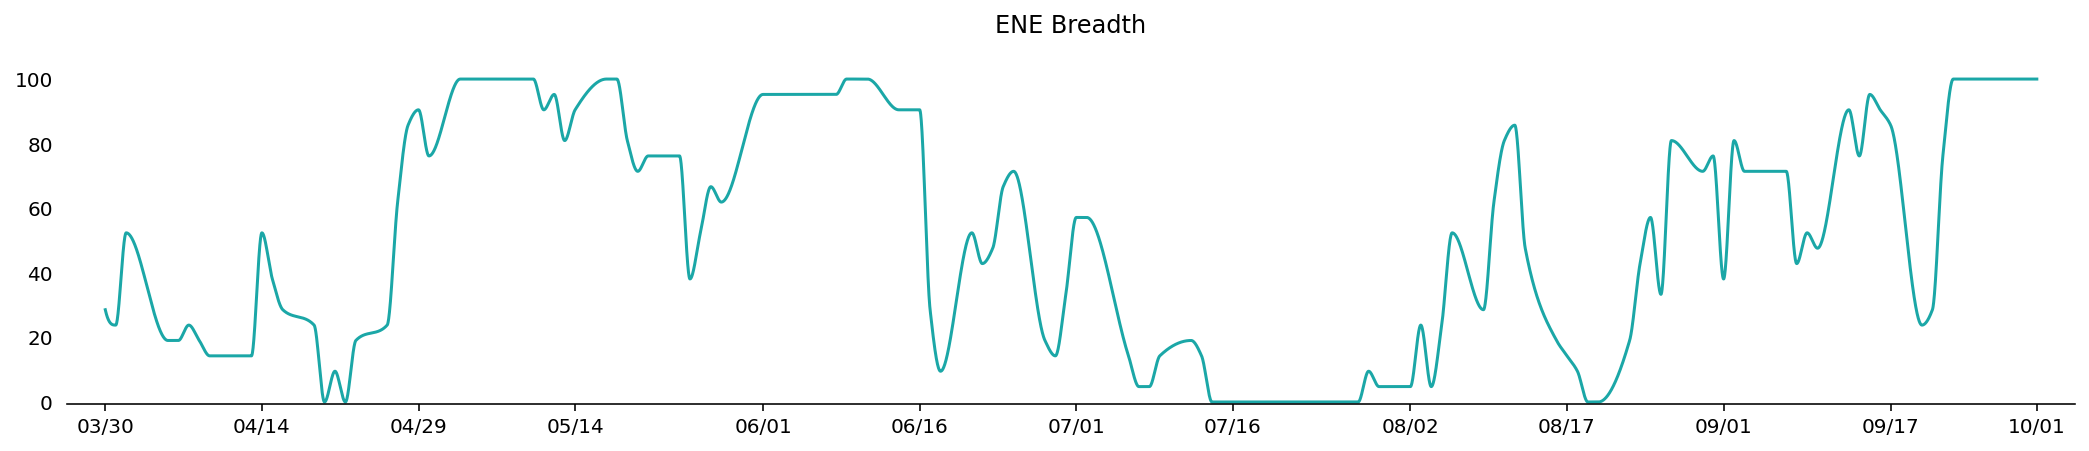

In [14]:
for sector in spx_sector_abbrev.values():
    breadth_six_mo = sector_breadth[sector][(date.today() - timedelta(days=185)).strftime("%Y-%m-%d"):]
    plot_breadth(breadth_six_mo, single_sector=True)

# 50 Day EMA Market Breadth
Earlier I also calculated the 50 day EMA for each stock, so let's also plot an SPX market breadth that's based on that:

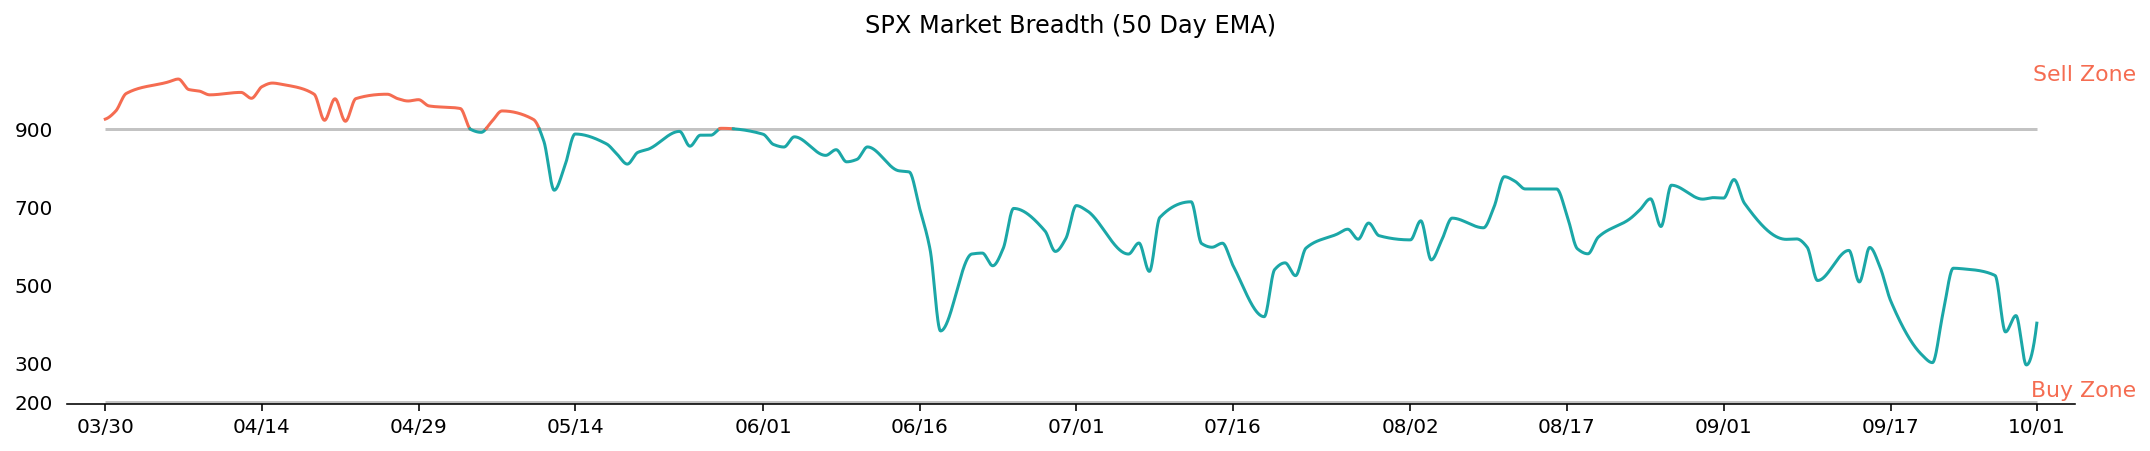

In [15]:
sector_breadth_50ema = {v: get_sector_breadth(sector_data[v], v, 'Close Above 50 Day EMA') for 
                        v in spx_sector_abbrev.values()}
mkt_breadth_50ema_six_mo = get_spx_breadth(sector_breadth_50ema)[(date.today() - timedelta(days=185)).
                                                                 strftime("%Y-%m-%d"):]
plot_breadth(mkt_breadth_50ema_six_mo, single_sector=False, title='SPX Market Breadth (50 Day EMA)')

# A Few Final Sanity Checks
The above visual comparison of my and breadth.app's 20 day SMA breadth graphs is all well and good, but let's make sure that our results are identical or at least reasonably close.

Here are the 20 day SMA market breadth datapoints from breadth.app for the past six months:

In [16]:
breadth_app = [786, 743,                                              # March 30 to 31
               838, 855, 876, 836, 825, 853, 867, 829, 898, 911, 928, # April
               893, 760, 881, 752, 815, 824, 805, 793, 866, 763,
               848, 776, 715, 782, 860, 808, 695, 451, 599, 705, 659, # May
               604, 476, 606, 604, 729, 570, 611, 684, 692, 
               715, 720, 707, 746, 703, 720, 667, 675, 702, 638, 648, # June
               493, 402, 211, 399, 376, 359, 417, 513, 428, 402, 442,
               576, 579, 475, 543, 448, 654, 700, 569, 597, 594, 520, # July
               324, 477, 543, 478, 612, 643, 632, 618, 741, 662,
               623, 694, 539, 698, 756, 688, 808, 780, 775, 751, 659, # August (Aug 10th missing on breadth.app)
               497, 454, 542, 603, 670, 696, 572, 748, 726, 761,
               719, 828, 736, 564, 581, 501, 380, 462, 372, 501, 466, # September
               343, 147, 131, 295, 443, 435, 449, 358, 394, 271,
               396]                                                   # October 1

Now let's plot my 20 day SMA breadth graph right on top of breadth.app's:

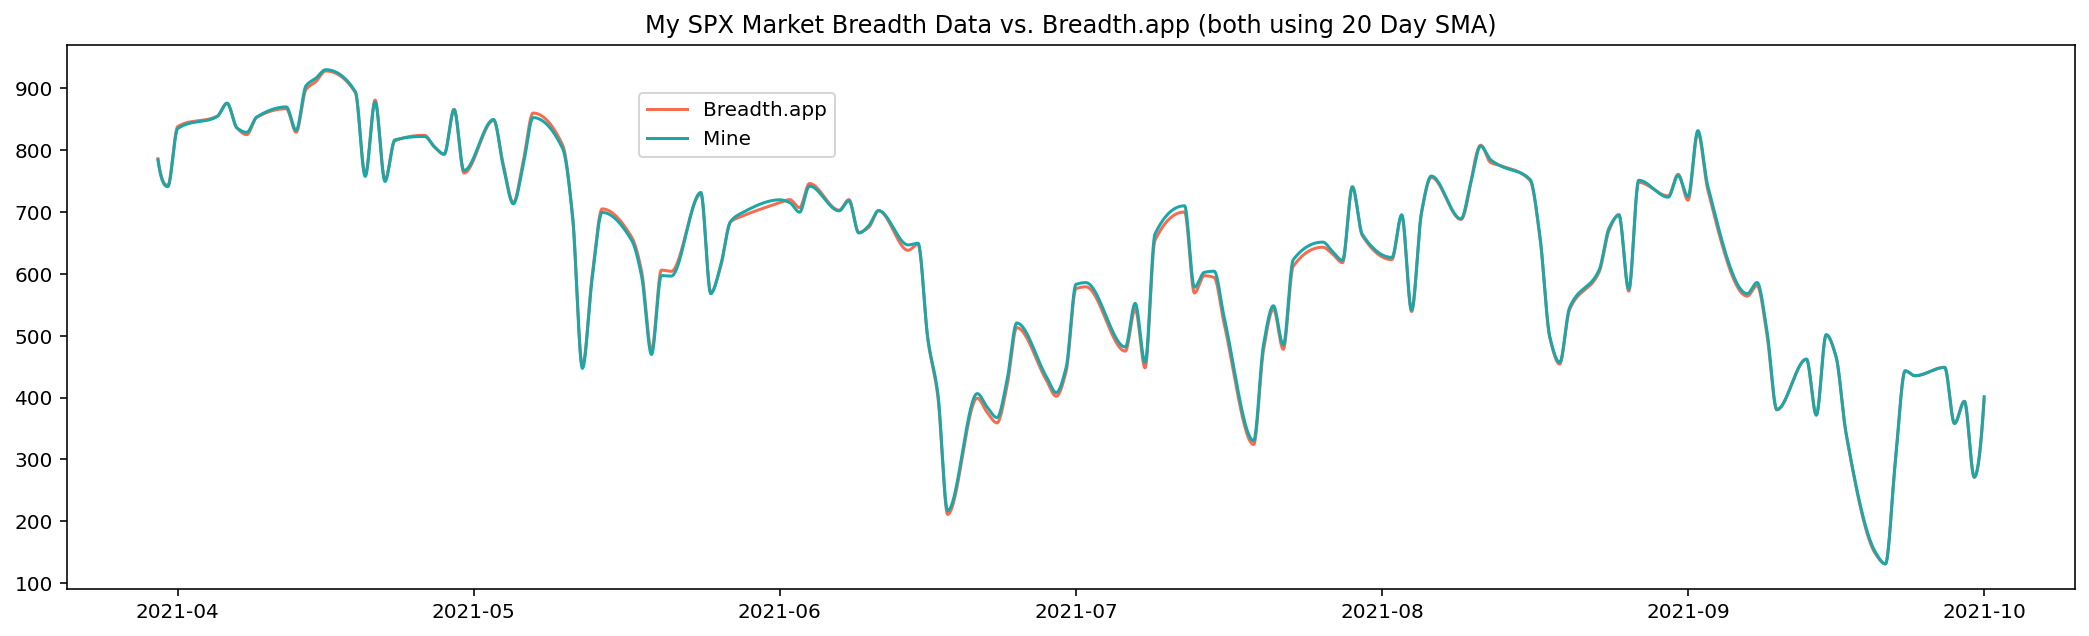

In [17]:
breadth_app = pd.Series(breadth_app, index=mkt_breadth_six_mo.drop(pd.to_datetime('2021-08-10')).index)
fig = plt.figure(figsize=[18,5])
ax = fig.add_subplot(1, 1, 1)
ax.set_title('My SPX Market Breadth Data vs. Breadth.app (both using 20 Day SMA)')
colors, labels = [RED, GREEN], ['Breadth.app', 'Mine']
for i, data in enumerate([breadth_app, mkt_breadth_six_mo]):
    X_, Y_ = smooth_time_series(data) 
    ax.plot(X_, Y_, color=colors[i], label=labels[i])
ax.legend(loc='best', bbox_to_anchor=(0.28, 0.43, 0.5, 0.5));

With the exception of a few minor discrepancies, it's obvious that both graphs are virtually identical. I don't have a good explanation as to why some small differences do exist. On June 1st, 2021 Breadth.app displays a market breadth of 715, while I calculated a breadth of 720.

<img src="images/breadth_0601.png" alt="6-1-2021 Market Breadth" width="400" align="left"/>

In [18]:
round(market_breadth.loc['2021-06-01'])

720

In this case, the disparity owed to the fact that they calculated breadths of 91% for the `ENE` sector and a 62% for `COM`, while I had breadths of 95% and 63% for these sectors, respectively.